In [9]:
import numpy as np
import numpy.matlib 
import math
import matplotlib.pyplot as plt
import csv

## THE TASK

We will use again the MNIST datasets, but in this case we will train two percpetrons, one with supervised learning and the other through RL.
For the training loop with RL, a reward of 1 is delivered if the correct action (the output that corresponds to the input image) is taken, and the reward will be zero otherwise. This is an example of an environment with immediate rewards, because the agent makes an action and receives a reward after presentation of an input image. 
The difference between RL and supervised learning is depicted below.

<img src="Supervised_RL.jpg" width="800" height="500">

In [10]:
# Load the MNIST dataset:

from scipy.io import loadmat

mnist = loadmat('MNIST.mat')

# Read the train set
x_train = mnist['x_train']
# Read the train labels
trainlabels = mnist['trainlabels']

# Read the test set
x_test = mnist['x_test']
# Read the test labels
testlabels = mnist['testlabels']

#We select the data for three classes that we want to classify

N_class=10 ## I will consider 10 classes from the beginning for the solutions

Index_tr=[]
Index_te=[]

for i in range(N_class):
    
    #Find the indexes of the training set corresponding to class i
    ind_tr=np.where(trainlabels==i)[0]
    #Find the indexes of the test set corresponding to class i
    ind_te=np.where(testlabels==i)[0]
    
    # Append the training indexes in a list
    Index_tr.append(ind_tr)
    # Append the testing indexes in a list
    Index_te.append(ind_te)

# Reshape the lists to be a 1-d array    
Index_tr=np.concatenate(Index_tr,axis=0)
Index_te=np.concatenate(Index_te,axis=0)

# Create a training set and a test set with data belonging to the classes considered only
X_tr=np.copy(x_train[Index_tr,:])
X_te=np.copy(x_test[Index_te,:])

# Compute the size of the train and test datasets
N_tr=np.shape(Index_tr)[0]
N_te=np.shape(Index_te)[0]

# Create one-hot encoding labels for train and test datasets
Y_tr=np.zeros([N_tr,N_class])
Y_te=np.zeros([N_te,N_class])

for i in range(N_tr):
    
    Y_tr[i,int(trainlabels[Index_tr[i]])]=1

for i in range(N_te):

    Y_te[i,int(testlabels[Index_te[i]])]=1



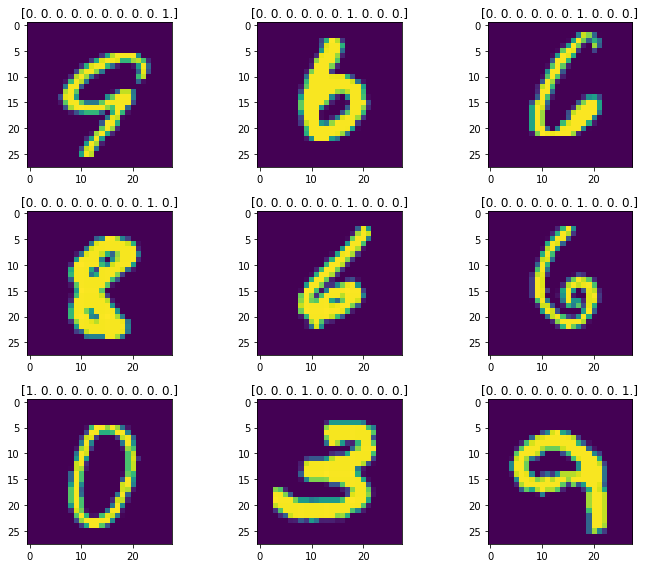

In [11]:
# Let's plot some examples

N_image_r=3

fig, axs = plt.subplots(N_image_r, N_image_r,figsize=(10,8))

for i in range(N_image_r):
    for j in range(N_image_r):
        
        random_ind=np.random.randint(0,N_tr)
        example_image=np.reshape(X_tr[random_ind],(28,28))
        
        axs[i,j].imshow(example_image.T)
        axs[i,j].title.set_text(np.array2string(Y_tr[random_ind,:]))

plt.tight_layout()

## Matrix multiplication, avoiding for loops

For this exercise, we will consider a different method to compute the network's activities and the gradients. 
In the previous lab (Lab1), we have used for loops to compute the response of the system for each sample in the minibatch.
Now, we will be using matrix multiplications. 

As in standard tools like Tensorflow and Pytorch, the first dimension will always be the dimension containing the different samples in the minibatch. Thus, our input $\mathbf{x}$ will be of shape $[batch_{size},784]$ for the minibatch considered. 

Then, performing matrix multiplications $\mathbf{x}\mathbf{W}$ (notice that the weights are of shape $[784,N_{class}]$) we will get outputs of shapes $[batch_{size},N_{class}]$ for all the samples in the minibatch at once. 

Finally, we will perform the updates of the parameters in a similar fashion.


In [12]:
## Definition of the epsilon-greedy policy. Notice that the shape of the Qvalues (input to the function) should be 
## [batch_size,N_actions]


def EpsilonGreedy_Policy(Qvalues, epsilon):
    

    N_class=np.shape(Qvalues)[1]
    batch_size=np.shape(Qvalues)[0]

    rand_values=np.random.uniform(0,1,[batch_size])

    rand_a=rand_values<epsilon
    a=np.zeros([batch_size,N_class])

    for i in range(batch_size):

        if rand_a[i]==True:

            a[i,np.random.randint(0,N_class)]=1

        else:

            a[i,np.argmax(Qvalues[i])]=1
            
    return a

## What is the probability of selecting the best action?
## Theoretically, it is (1-epsilon)+epsilon*1/N_class, where the first term corresponds to selecting the greedy action, while the
## second term corresponds to select a random action that corresponds to the greedy action
## Let' s check that this is true

epsilon=0.4

# Generate 100000 Q-values
Qvalues=np.random.randn(100000,N_class)

# Greedy policy
greedy=np.argmax(Qvalues,1)

# Epsilon-greedy policy
actions=EpsilonGreedy_Policy(Qvalues,epsilon)

print('Theoretical: ', 1/N_class*epsilon+(1-epsilon), 'Model: ',  np.mean(greedy==np.argmax(actions,1)))



Theoretical:  0.64 Model:  0.6392


In [13]:
# Hyperparameters

N_minibatch=20000
batch_size=12

n_input=np.shape(X_tr)[1]

eta=0.0001

epison=0.4


In [14]:
## Let's define Adam, see notebook Adam's playgroud for more information

class Adam:

    def __init__(self, Params, beta1):
        
        N_dim=np.shape(np.shape(Params))[0] # It finds out if the parameters given are in a vector (N_dim=1) or a matrix (N_dim=2)
        
        # INITIALISATION OF THE MOMENTUMS
        if N_dim==1:
               
            self.N1=np.shape(Params)[0]
            
            self.mt=np.zeros([self.N1])
            self.vt=np.zeros([self.N1])
        
        if N_dim==2:
            
            self.N1=np.shape(Params)[0]
            self.N2=np.shape(Params)[1]
        
            self.mt=np.zeros([self.N1,self.N2])
            self.vt=np.zeros([self.N1,self.N2])
        
        # HYPERPARAMETERS OF ADAM
        self.beta1=beta1
        self.beta2=0.999
        
        self.epsilon=10**(-8)
        
        # COUNTER OF THE TRAINING PROCESS
        self.counter=0
        
        
    def Compute(self,Grads):
                
        self.counter=self.counter+1
        
        self.mt=self.beta1*self.mt+(1-self.beta1)*Grads
        
        self.vt=self.beta2*self.vt+(1-self.beta2)*Grads**2
        
        mt_n=self.mt/(1-self.beta1**self.counter)
        vt_n=self.vt/(1-self.beta2**self.counter)
        
        New_grads=mt_n/(np.sqrt(vt_n)+self.epsilon)
        
        return New_grads

beta1=0.9 # First order momentum for Adam

In [15]:
## Training Loop

## WE HAVE TWO PERCEPTRONS, ONE TRAINED WITH RL AND THE OTHER WITH SUPERVISED LEARNING
## YOU WILL HAVE TO TRAIN THE RL NETWORK AND PLOT THE AVERAGE REWARD AS TRAINING PROGRESSES
## THE CODE FOR THE SUPERVISED LEARNING NETWORK HAS BEEN GIVEN
## PLEASE NOTE THAT IN RL YOU NEED TO UPDATE ONLY THE PARAMETERS CORRESPONDING TO THE ACTIONS TAKEN


# Let's initialise the weights and the bias for the perceptron 
W=np.random.randn(n_input,N_class)/np.sqrt(n_input)
b=np.zeros([1,N_class])


# Let's create a copy of the parameters to be optimised using Adam
W_A=np.copy(W)
b_A=np.copy(b)

# Intialise Adam for the parameters
Adam_W=Adam(W_A,beta1)
Adam_b=Adam(b_A,beta1)


## Define after how many minibatches we will compute the performance 
N_check=100

## Number of times in which we will compute the performance
N_perf=int(np.round(N_minibatch/N_check))

# Save Performance
Average_R=np.zeros([N_perf])   # Average reward for RL without Adam
Average_R_A=np.zeros([N_perf]) # Average reward for RL with Adam


for n in range(N_minibatch):
        
    ## Let's select batch_size training images, which are sampled randomly from the dataset
    
    batch_ind=np.random.randint(0,N_tr,[batch_size])
    
    # The input, of shape [batch_size,784]
    x=np.copy(X_tr[batch_ind,:])
    
    # The desired output (in one hot encoding), of shape [batch_size,3]
    y_true=np.copy(Y_tr[batch_ind,:])
    
    
    ## REINFORCEMENT LEARNING
    
    # The Qvalues correspond to the output of the network
    Qvalues=np.matmul(x,W)+np.tile(b,[batch_size,1])
    
    # Computation of the epsilon greedy policy
    actions=EpsilonGreedy_Policy(Qvalues,epsilon)
    
    # Computation of the reward for each image. R=1 for the correct classification, 0 otherwise
    R=np.int32(np.argmax(y_true,1)==np.argmax(actions,1))
    
    # We replicate the rewards to obtain a reward of the same shape of the Qvalues, which is [batch_size,N_class], this
    # operation will be useful to compute the updates.
    R_rep=np.tile(np.expand_dims(R,1),[1,N_class])
    
    # We will compute a delta for each sample. For computation purposes, we would like to have a delta of dimension 
    # [batch_size,N_class]  (instead of a delta of size [N_batch]), so that we can compute the delta_W with a 
    # simple matrix product as in supervised  learning. 
    # (R_rep-Qvalues) will have shape [batch_size,N_class], but its values should be zero for all the actions that were not made.
    # To do this, we can compute (R_rep-Qvalues)*actions, which will be R-Q(a,s) only for the actions made, and zero otherwise. 
    
    delta=(R_rep-Qvalues)*actions
    
    # np.transpose(x) is of size [784,batch_size], while delta is of size [batch_size,N_class]. 
    # Their product is of size [784,N_class] and gives us exatly the delta for the weights, summing the samples in the minibatch.
    delta_W=np.matmul(np.transpose(x),delta)
    
    # delta_b is the sum of the delta [minbatch,N_class] across the minibatch, to obtain the shape of the bias [1,N_class]
    delta_b=np.expand_dims(np.sum(delta,0),0)
    
    W=W+eta*delta_W
    b=b+eta*delta_b
    
    ## REINFORCEMENT LEARNING WITH ADAM
    
    Qvalues=np.matmul(x,W_A)+np.tile(b_A,[batch_size,1]) # I won't rename Qvalues and some other variables for convenience
    actions=EpsilonGreedy_Policy(Qvalues,epsilon)
    R=np.int32(np.argmax(y_true,1)==np.argmax(actions,1))
    R_rep=np.tile(np.expand_dims(R,1),[1,N_class])
    delta=(R_rep-Qvalues)*actions
    delta_W=np.matmul(np.transpose(x),delta)
    delta_b=np.expand_dims(np.sum(delta,0),0)    
    W_A=W_A+eta*Adam_W.Compute(delta_W)
    b_A=b_A+eta*Adam_b.Compute(delta_b)
    
    
    # Every ten iterations we compute the performance of the two networks, one trained with supervised learning and the other 
    # with RL. For RL, we will use the greedy policy while testing, to exploit and report the accuracy.
    if n%N_check==0:
        
        x=np.copy(X_te)
        y_true=np.copy(Y_te)
        
        
        ## REINFORCEMENT LEARNING, performance on the test set
        
        # without Adam
        Qvalues=np.matmul(x,W)+np.tile(b,[N_te,1])
    
        actions=np.argmax(Qvalues,1)
        R_te=np.int32(np.argmax(y_true,1)==actions)
                    
        # with Adam 
        Qvalues=np.matmul(x,W_A)+np.tile(b_A,[N_te,1])
    
        actions=np.argmax(Qvalues,1)
        R_te_A=np.int32(np.argmax(y_true,1)==actions)
                    
        print('Minibatch number ',n, 'REINFORCEMENT LEARNING: Average test reward with and without Adam ',np.mean(R_te_A),np.mean(R_te))
        
        ind_save=int(n/N_check)
        Average_R[ind_save]=np.mean(R_te)
        
        Average_R_A[ind_save]=np.mean(R_te_A)
        

KeyboardInterrupt: 

Text(0, 0.5, 'Average reward (Reinforcement)')

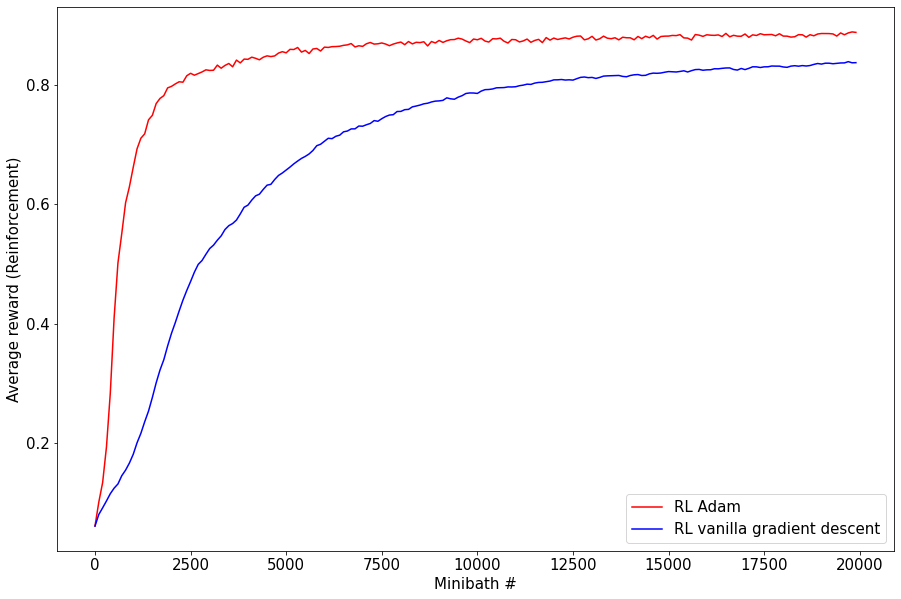

In [20]:
plt.rcParams.update({'font.size': 15})

fig, axs = plt.subplots(1,figsize=(15,10))

RL_A,=axs.plot(np.arange(0,N_perf)*N_check,Average_R_A,'r')
RL,=axs.plot(np.arange(0,N_perf)*N_check,Average_R,'b')

axs.legend([RL_A,RL],['RL Adam','RL vanilla gradient descent'])
plt.xlabel('Minibath #')
plt.ylabel('Average reward (Reinforcement)')


## Final exercises


1. Given the performance of the RL model after training using a greedy policy, what is the accuracy for an epsilon greedy policy?
    

2. If you increase the number of output classes, how will RL perform in comparison to supervised learning? 
    Do the simulation and use all ten classes


3. Use Adam for the simulation with ten classes

